In [33]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
import time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,precision_score,accuracy_score,recall_score,f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import math
import scipy.stats as stats

# **1 Data Preparation**

In [34]:
digits = load_digits ()
print (digits . keys ())
data = digits ["data"]
images = digits ["images"]
target = digits ["target"]
target_names = digits ["target_names"]
print (data.dtype)

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
float64


In [35]:
from sklearn import model_selection
X_all = data
y_all = target
X_train , X_test , y_train , y_test = model_selection.train_test_split(digits.data, digits.target, test_size = 0.4, random_state = 0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1078, 64) (719, 64) (1078,) (719,)


In [36]:
X_test_1 = X_test[np.argwhere(y_test == 1)]
X_train_1 = X_train[np.argwhere(y_train == 1)]
X_train_1.reshape((len(X_train_1), 64))
y_train_1 = y_train[np.argwhere(y_train == 1)]
y_test_1 = y_test[np.argwhere(y_test == 1)]

X_test_7 = X_test[np.argwhere(y_test == 7)]
X_train_7 = X_train[np.argwhere(y_train == 7)]
X_train_7.reshape((len(X_train_7), 64))
y_train_7 = y_train[np.argwhere(y_train == 7)]
y_test_7 = y_test[np.argwhere(y_test == 7)]

X_train_1_7 = np.append(X_train_1, X_train_7).reshape((len(X_train_1)+len(X_train_7), 64))
y_train_1_7 = np.append(y_train_1, y_train_7).astype(int)

X_test_1_7 = np.append(X_test_1, X_test_7).reshape((len(X_test_1)+len(X_test_7), 64))
y_test_1_7 = np.append(y_test_1, y_test_7).astype(int)

In [37]:
print(X_train_1_7.shape, X_test_1_7.shape)

(223, 64) (138, 64)


**1.1 Dimension Reduction**

<Figure size 432x288 with 0 Axes>

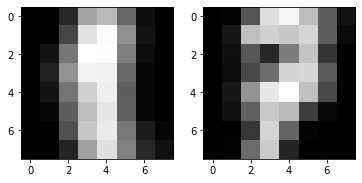

In [38]:
X_train_1_all = np.mean(X_train_1, axis=0)
X_train_1_all = np.reshape(X_train_1_all, (8,8))
X_train_7_all = np.mean(X_train_7, axis=0)
X_train_7_all = np.reshape(X_train_7_all, (8,8))
plt.figure ()
plt.gray ()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(X_train_1_all, interpolation ="nearest" )
axarr[1].imshow(X_train_7_all, interpolation ="nearest")
plt.show ()

As it can be seen in the above, column 4 of 1's is brighter than column 4 of 7's averagly.

Also note that, first row is brighter for 7's averagly.

In [39]:
def reduce_dim(x):
  # average features
  first_row = np.zeros((7,8))
  first_row = np.insert(first_row, 0, 1, axis=0)
  fourth_column = np.zeros((8,7))
  fourth_column = np.insert(fourth_column, 4, 1, axis=1)

  # very good features
  """first_row = np.zeros((8,8))
  first_row[2][3] = 1
  first_row[2][4] = 1
  #first_row = np.insert(first_row, 2, 1, axis=0)
  fourth_column = np.zeros((8,8))
  fourth_column[6][4] = 1
  fourth_column[7][4] = 1"""

  first_row = np.reshape(first_row, (64, 1))
  fourth_column = np.reshape(fourth_column, (64, 1))

  output = x @ first_row
  output = np.concatenate((output, x @ fourth_column), axis=1)
  return output

In [40]:
reduced_x_train = reduce_dim(X_train_1_7)
reduced_x_test = reduce_dim(X_test_1_7)

**1.2 Scatterplot**

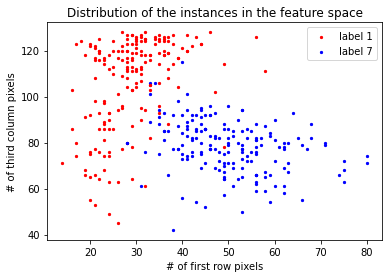

In [41]:
plt.scatter(reduced_x_train[np.where(y_train_1_7==1),0],reduced_x_train[np.where(y_train_1_7==1),1],s=5,color="r",label="label 1")
plt.scatter(reduced_x_train[np.where(y_train_1_7==7),0],reduced_x_train[np.where(y_train_1_7==7),1],s=5,color="b",label="label 7")
plt.scatter(reduced_x_test[np.where(y_test_1_7==1),0],reduced_x_test[np.where(y_test_1_7==1),1],s=5,color="r")
plt.scatter(reduced_x_test[np.where(y_test_1_7==7),0],reduced_x_test[np.where(y_test_1_7==7),1],s=5,color="b")
plt.legend()
plt.xlabel("# of first row pixels")
plt.ylabel("# of third column pixels")
plt.title("Distribution of the instances in the feature space")
plt.show()

# **2 Nearest Mean**

**2.1 Implement the nearest mean classifier**

In [42]:
def mean_finder(training_features, training_labels):
  label_1_mean = np.mean(training_features[np.where(training_labels==1)], axis=0)
  label_7_mean = np.mean(training_features[np.where(training_labels==7)], axis=0)
  return label_1_mean, label_7_mean

In [43]:
def nearest_mean(training_features, training_labels, test_features):
    label_1_mean, label_7_mean = mean_finder(training_features, training_labels)

    label_1_mean_full = np.full((len(test_features), len(test_features[0])), label_1_mean)
    label_7_mean_full = np.full((len(test_features), len(test_features[0])), label_7_mean)

    label_1_dist = np.linalg.norm(test_features - label_1_mean_full, axis=1)
    label_7_dist = np.linalg.norm(test_features - label_7_mean_full, axis=1)

    output = np.ones(len(test_features))
    output[label_1_dist > label_7_dist] = 7

    return output

**2.2 Visualize the decision regions**

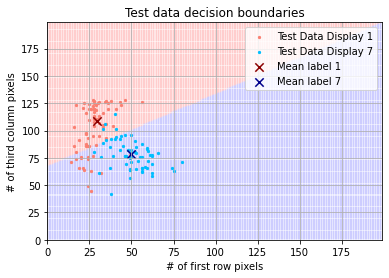

In [44]:
axis_dim_1 = 200
step = 199

create_feat_set_ind_1, create_feat_set_ind_2 = np.meshgrid(np.linspace(0, step, axis_dim_1), np.linspace(0, step, axis_dim_1))
created_feat_set = np.concatenate((np.reshape(create_feat_set_ind_1, (axis_dim_1*axis_dim_1, 1)), np.reshape(create_feat_set_ind_2, (axis_dim_1*axis_dim_1, 1))), axis=1)

label_1_mean, label_7_mean = mean_finder(reduced_x_train, y_train_1_7)
prediction_created_feat_set = np.reshape(nearest_mean(reduced_x_train, y_train_1_7, created_feat_set), (axis_dim_1, axis_dim_1))

plt.figure()
plt.pcolormesh(create_feat_set_ind_1, create_feat_set_ind_2, prediction_created_feat_set, alpha=0.05, cmap="bwr_r")
plt.grid(True)

plt.scatter(reduced_x_test[np.where(y_test_1_7==1),0], reduced_x_test[np.where(y_test_1_7==1),1], s=5, color="salmon", label="Test Data Display 1")
plt.scatter(reduced_x_test[np.where(y_test_1_7==7),0], reduced_x_test[np.where(y_test_1_7==7),1], s=5, color="deepskyblue", label="Test Data Display 7")

plt.scatter(label_1_mean[0], label_1_mean[1], s=70, marker="x", color="darkred", label="Mean label 1")
plt.scatter(label_7_mean[0], label_7_mean[1], s=70, marker="x", color="darkblue", label="Mean label 7")

plt.legend()
plt.xlabel("# of first row pixels")
plt.ylabel("# of third column pixels")
plt.title("Test data decision boundaries")
plt.show()

In [45]:
predicted_labels_test = nearest_mean(reduced_x_train, y_train_1_7, reduced_x_test)

print("test set error rate: ", error_rate_lda(predicted_labels_test, y_test_1_7), "%")

test set error rate:  14.492753623188403 %


# **3 QDA**

**3.1 Implement QDA Training**

In [46]:
def fit_qda(training_features, training_labels):
  classes, y_idx = np.unique(training_labels, return_inverse = True)
  ts_k_count = np.bincount(training_labels)[(np.bincount(training_labels) != 0)]
  p = ts_k_count / len(training_labels)

  means = np.zeros((len(classes), len(training_features[0])))
  np.add.at(means, y_idx, training_features)
  mu = (means.T/ts_k_count).T

  covmat = np.array([np.cov(training_features[training_labels == group].T) for idx, group in enumerate(classes)])
  
  # below not working
  """covmat2 = [((training_features[training_labels == group] - mu[idx]).T @ (training_features[training_labels == group] - mu[idx])) for idx, group in enumerate(classes)]
  covmat2 = covmat2 / ts_k_count"""

  return mu, covmat, p

In [47]:
mu, covmat, p = fit_qda(reduced_x_train, y_train_1_7)

print(mu.shape)
print(covmat.shape)
print(p.shape)

(2, 2)
(2, 2, 2)
(2,)


**3.2 Implement QDA Prediction**

In [48]:
classes = np.unique(y_train_1_7)
def predict_qda(mu, covmat, p, test_features):
    b_k = np.log(np.linalg.det(2*np.pi*covmat)) / 2 - np.log(p)
    y_test = np.array([np.sum((test_features-mu[idx]) * np.matmul(np.linalg.inv(covmat[idx]), (test_features-mu[idx]).T).T, axis=1) / 2 + b_k[idx] for idx, group in enumerate(classes)])
    pred = np.full(len(y_test[0]), classes[0])
    for x in range(len(y_test)-1):
      pred[y_test[x] > y_test[x+1]] = classes[x+1]
    return pred

In [49]:
def error_rate_qda(prediction, label):
    return 100 * (1 - np.count_nonzero(prediction == label) / len(prediction))

predicted_labels_test = predict_qda(mu, covmat, p, reduced_x_test)
predicted_labels_train = predict_qda(mu, covmat, p, reduced_x_train)

print("test set error rate: ", error_rate_qda(predicted_labels_test, y_test_1_7), "%")
print("train set error rate: ", error_rate_qda(predicted_labels_train, y_train_1_7), "%")

test set error rate:  6.521739130434778 %
train set error rate:  4.0358744394618835 %


**3.3 Visualization**

In [50]:
def gaussian_2D(x,y,mean,sigma):
    determinant = sigma[0,0]*sigma[1,1]-sigma[1,0]**2
    gaussian = np.exp(-(sigma[1,1]*(x-mean[0])**2 + 2*sigma[1,0]*(y-mean[1])*(x-mean[0]) + sigma[0,0]*(y-mean[1])**2) / (determinant * np.sqrt(2*np.pi)))
    return gaussian

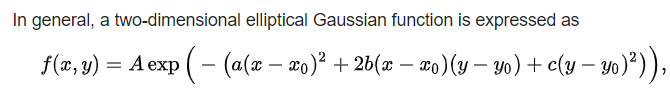

where $\mathrm A = 1 \div (det * \sqrt{2*pi})$


and where $det$ is the determinant of covmat matrix.

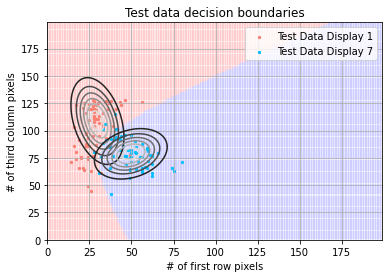

In [51]:
axis_dim_1 = 200
step = 199

create_feat_set_ind_1, create_feat_set_ind_2 = np.meshgrid(np.linspace(0, step, axis_dim_1), np.linspace(0, step, axis_dim_1))
created_feat_set = np.concatenate((np.reshape(create_feat_set_ind_1, (axis_dim_1*axis_dim_1, 1)), np.reshape(create_feat_set_ind_2, (axis_dim_1*axis_dim_1, 1))), axis=1)

label_1_mean, label_7_mean = mean_finder(reduced_x_train, y_train_1_7)
prediction_created_feat_set = np.reshape(predict_qda(mu, covmat, p, created_feat_set), (axis_dim_1, axis_dim_1))

gaussian_1 = gaussian_2D(create_feat_set_ind_1, create_feat_set_ind_2, mu[0], covmat[0])
gaussian_7 = gaussian_2D(create_feat_set_ind_1, create_feat_set_ind_2, mu[1], covmat[1])

plt.figure()
plt.pcolormesh(create_feat_set_ind_1, create_feat_set_ind_2, prediction_created_feat_set, alpha=0.05, cmap="bwr_r")
plt.grid(True)

plt.contour(create_feat_set_ind_1, create_feat_set_ind_2, gaussian_1)
plt.contour(create_feat_set_ind_1, create_feat_set_ind_2, gaussian_7)

plt.scatter(reduced_x_test[np.where(y_test_1_7==1),0], reduced_x_test[np.where(y_test_1_7==1),1], s=5, color="salmon", label="Test Data Display 1")
plt.scatter(reduced_x_test[np.where(y_test_1_7==7),0], reduced_x_test[np.where(y_test_1_7==7),1], s=5, color="deepskyblue", label="Test Data Display 7")

plt.legend()
plt.xlabel("# of first row pixels")
plt.ylabel("# of third column pixels")
plt.title("Test data decision boundaries")
plt.show()

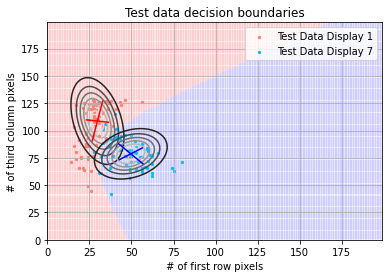

In [52]:
eig_values, eig_vectors = np.linalg.eig(covmat)

plt.figure()
plt.pcolormesh(create_feat_set_ind_1, create_feat_set_ind_2, prediction_created_feat_set, alpha=0.05, cmap="bwr_r")
plt.grid(True)

plt.contour(create_feat_set_ind_1, create_feat_set_ind_2, gaussian_1)
plt.contour(create_feat_set_ind_1, create_feat_set_ind_2, gaussian_7)

plt.scatter(reduced_x_test[np.where(y_test_1_7==1),0], reduced_x_test[np.where(y_test_1_7==1),1], s=5, color="salmon", label="Test Data Display 1")
plt.scatter(reduced_x_test[np.where(y_test_1_7==7),0], reduced_x_test[np.where(y_test_1_7==7),1], s=5, color="deepskyblue", label="Test Data Display 7")

for j in range(len(eig_values)):
  for k in range(len(eig_values[0])):
    a = mu[j] + np.sqrt(eig_values[j][k]) * eig_vectors[j].T[k]
    b = mu[j] - np.sqrt(eig_values[j][k]) * eig_vectors[j].T[k]
    if(j == 0):
      plt.plot([a[0],b[0]], [a[1],b[1]], color="r")
    else:
      plt.plot([a[0],b[0]], [a[1],b[1]], color="b")

plt.legend()
plt.xlabel("# of first row pixels")
plt.ylabel("# of third column pixels")
plt.title("Test data decision boundaries")
plt.show()

Training errors in QDA classification stem from the common areas on the above plot. Since the applied two features could not distinguish or separate the labels, the algorithm makes misclassified predictions. In the training part, nearest neighbor(nn) classifier labels the given datapoints one by one. In other words, nn classifier does not have a general approach to estimate the label of the given data but it specifically labels each data.

**3.4 Performance evaluation**

In [53]:
from sklearn.model_selection import KFold

x_set_all = np.append(reduced_x_test, reduced_x_train).reshape(len(reduced_x_test) + len(reduced_x_train), -1)
y_set_all = np.append(y_test_1_7, y_train_1_7)

def cross_validation(fold_no):

    error_arr = []
    kf = KFold(fold_no)

    for train_index, test_index in kf.split(y_set_all):
        x_train = x_set_all[train_index]
        y_train = y_set_all[train_index]
        x_test = x_set_all[test_index]
        y_test = y_set_all[test_index]

        mu, covmat, p = fit_qda(x_train, y_train)
        predictions = predict_qda(mu, covmat, p, x_test)
        error_arr.append(100 * (1 - np.count_nonzero(predictions == y_test) / len(predictions)))

    return np.mean(error_arr), np.std(error_arr)

Mean error: 5.83 with std: (+/- 5.19) %


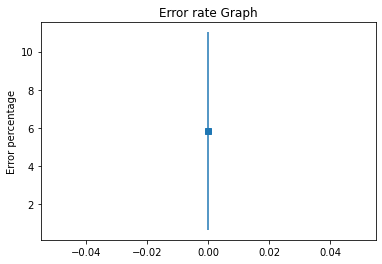

In [54]:
mean, std = cross_validation(10)

print("Mean error: %0.2f with std: (+/- %0.2f)" % (mean, std), "%")

plt.errorbar(x=0, y=mean, yerr=std, fmt='s')
plt.ylabel("Error percentage")
plt.title("Error rate Graph")
plt.show()

Or we can also call this QuadraticDiscriminantAnalysis function ,which is in sklearn.

[[71  2]
 [ 7 58]]
0.9347826086956522 0.9102564102564102 0.9726027397260274 0.9403973509933774


No handles with labels found to put in legend.


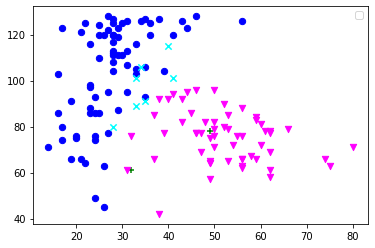

In [55]:
clf=QuadraticDiscriminantAnalysis()
clf.fit(reduced_x_train, y_train_1_7)
y_pred=clf.predict(reduced_x_test)
con = confusion_matrix(y_test_1_7, y_pred)
print(con)
print(accuracy_score(y_test_1_7, y_pred),
      precision_score(y_test_1_7, y_pred),
      recall_score(y_test_1_7,y_pred),f1_score(y_test_1_7, y_pred))
for i in range(0,len(y_test_1_7)):
    if y_pred[i]!=y_test_1_7[i]:
        if y_test_1_7[i]==1:
            plt.scatter(reduced_x_test[i,0],reduced_x_test[i,1], marker = '+', color = 'green', s = 40)#wrong1
        if y_test_1_7[i]==7:
            plt.scatter(reduced_x_test[i,0],reduced_x_test[i,1],marker = 'x', color = 'cyan', s = 40)#wrong0
    else:
        if y_test_1_7[i]==1:
            plt.scatter(reduced_x_test[i,0],reduced_x_test[i,1], marker = 'o', color = 'blue', s = 40)#right1
        if y_test_1_7[i]==7:
            plt.scatter(reduced_x_test[i,0],reduced_x_test[i,1], marker = 'v', color = 'magenta', s = 40)#right0
plt.legend(loc = 'best')
plt.show()

# **4 LDA**

**4.1 Implement LDA Training**

In [56]:
def fit_lda(training_features, training_labels):
  classes, y_idx = np.unique(training_labels, return_inverse = True)
  ts_k_count = np.bincount(training_labels)[(np.bincount(training_labels) != 0)]
  p = ts_k_count / len(training_labels)

  means = np.zeros((len(classes), len(training_features[0])))
  np.add.at(means, y_idx, training_features)
  mu = (means.T/ts_k_count).T

  cov_i = [np.cov(training_features[training_labels == group].T) for idx, group in enumerate(classes)]
  covmat = sum(cov_i) / len(cov_i)

  return p, mu, covmat

In [57]:
p, mu, covmat = fit_lda(reduced_x_train, y_train_1_7)

print(mu.shape)
print(covmat.shape)
print(p.shape)

(2, 2)
(2, 2)
(2,)


**4.2 Implement LDA Prediction**

In [58]:
classes = np.unique(y_train_1_7)
def predict_lda(mu, covmat, p, test_features):
    b_k = np.log(np.linalg.det(2*np.pi*covmat)) / 2 - np.log(p)
    b_k_hat = np.array([np.sum(mu[idx] * np.linalg.inv(covmat) * mu[idx].T).T / 2 + b_k[idx] for idx, group in enumerate(classes)])
    y_test = np.array([np.sum(mu[idx] * (np.linalg.inv(covmat) @ test_features.T).T, axis=1) - b_k_hat[idx] for idx, group in enumerate(classes)])
    pred = np.full(len(y_test[0]), classes[0])
    for x in range(len(y_test)-1):
      pred[y_test[x] < y_test[x+1]] = classes[x+1]
    return pred

In [59]:
def error_rate_lda(prediction, label):
    return 100 * (1 - np.count_nonzero(prediction == label) / len(prediction))

predicted_labels_test = predict_lda(mu, covmat, p, reduced_x_test)
predicted_labels_train = predict_lda(mu, covmat, p, reduced_x_train)

print("test set error rate: ", error_rate_lda(predicted_labels_test, y_test_1_7), "%")
print("train set error rate: ", error_rate_lda(predicted_labels_train, y_train_1_7), "%")

test set error rate:  13.768115942028981 %
train set error rate:  8.520179372197312 %


**4.3 Visualization**

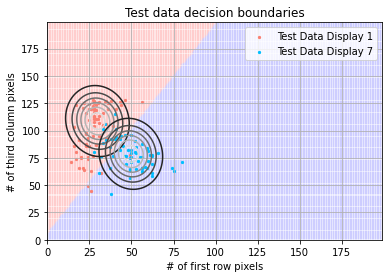

In [60]:
axis_dim_1 = 200
step = 199

create_feat_set_ind_1, create_feat_set_ind_2 = np.meshgrid(np.linspace(0, step, axis_dim_1), np.linspace(0, step, axis_dim_1))
created_feat_set = np.concatenate((np.reshape(create_feat_set_ind_1, (axis_dim_1*axis_dim_1, 1)), np.reshape(create_feat_set_ind_2, (axis_dim_1*axis_dim_1, 1))), axis=1)

label_1_mean, label_7_mean = mean_finder(reduced_x_train, y_train_1_7)
prediction_created_feat_set = np.reshape(predict_lda(mu, covmat, p, created_feat_set), (axis_dim_1, axis_dim_1))

gaussian_1 = gaussian_2D(create_feat_set_ind_1, create_feat_set_ind_2, mu[0], covmat)
gaussian_7 = gaussian_2D(create_feat_set_ind_1, create_feat_set_ind_2, mu[1], covmat)

plt.figure()
plt.pcolormesh(create_feat_set_ind_1, create_feat_set_ind_2, prediction_created_feat_set, alpha=0.05, cmap="bwr_r")
plt.grid(True)

plt.contour(create_feat_set_ind_1, create_feat_set_ind_2, gaussian_1)
plt.contour(create_feat_set_ind_1, create_feat_set_ind_2, gaussian_7)

plt.scatter(reduced_x_test[np.where(y_test_1_7==1),0], reduced_x_test[np.where(y_test_1_7==1),1], s=5, color="salmon", label="Test Data Display 1")
plt.scatter(reduced_x_test[np.where(y_test_1_7==7),0], reduced_x_test[np.where(y_test_1_7==7),1], s=5, color="deepskyblue", label="Test Data Display 7")

plt.legend()
plt.xlabel("# of first row pixels")
plt.ylabel("# of third column pixels")
plt.title("Test data decision boundaries")
plt.show()

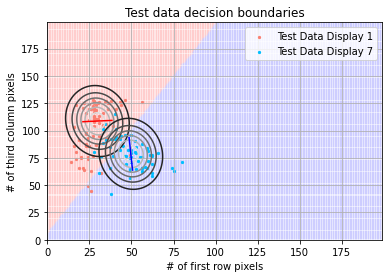

In [61]:
eig_values, eig_vectors = np.linalg.eig(covmat)

plt.figure()
plt.pcolormesh(create_feat_set_ind_1, create_feat_set_ind_2, prediction_created_feat_set, alpha=0.05, cmap="bwr_r")
plt.grid(True)

plt.contour(create_feat_set_ind_1, create_feat_set_ind_2, gaussian_1)
plt.contour(create_feat_set_ind_1, create_feat_set_ind_2, gaussian_7)

plt.scatter(reduced_x_test[np.where(y_test_1_7==1),0], reduced_x_test[np.where(y_test_1_7==1),1], s=5, color="salmon", label="Test Data Display 1")
plt.scatter(reduced_x_test[np.where(y_test_1_7==7),0], reduced_x_test[np.where(y_test_1_7==7),1], s=5, color="deepskyblue", label="Test Data Display 7")

for j in range(len(eig_values)):
  a = mu[j] + np.sqrt(eig_values[j]) * eig_vectors[j].T
  b = mu[j] - np.sqrt(eig_values[j]) * eig_vectors[j].T
  if(j == 0):
    plt.plot([a[0],b[0]], [a[1],b[1]], color="r")
  else:
    plt.plot([a[0],b[0]], [a[1],b[1]], color="b")

plt.legend()
plt.xlabel("# of first row pixels")
plt.ylabel("# of third column pixels")
plt.title("Test data decision boundaries")
plt.show()

**4.4 Performance evaluation**

In [62]:
def cross_validation_lda(fold_no):

    error_arr = []
    kf = KFold(fold_no)

    for train_index, test_index in kf.split(y_set_all):
        x_train = x_set_all[train_index]
        y_train = y_set_all[train_index]
        x_test = x_set_all[test_index]
        y_test = y_set_all[test_index]

        p, mu, covmat = fit_lda(x_train, y_train)
        predictions = predict_lda(mu, covmat, p, x_test)
        error_arr.append(100 * (1 - np.count_nonzero(predictions == y_test) / len(predictions)))

    return np.mean(error_arr), np.std(error_arr)

Mean error: 11.66 with std: (+/- 10.82) %


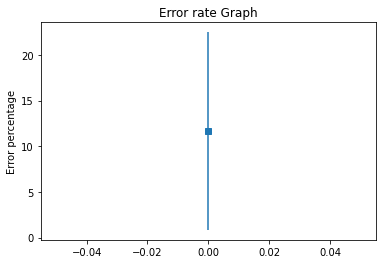

In [63]:
mean, std = cross_validation_lda(10)

print("Mean error: %0.2f with std: (+/- %0.2f)" % (mean, std), "%")

plt.errorbar(x=0, y=mean, yerr=std, fmt='s')
plt.ylabel("Error percentage")
plt.title("Error rate Graph")
plt.show()

As it can be seen in the Performance Evaluation section of the QDA and LDA classifiers, QDA classifier has less error percentage and standard deviation. This is mainly because the applied features could not separate the labels linearly. We can say that for non-linear datapoints it is better to use QDA for classification.

LDA classifier has lower error rate than Nearest Mean classifier but the diffrence is not much.

Overall, the best classifier for this task is QDA, since the lowest error rate is achived with QDA.

There is also another function LinearDiscriminantAnalysis in Sklearn. We can compare this function with our LDA function, which is built by ourself.

[[68  5]
 [ 8 57]]
0.9057971014492754 0.8947368421052632 0.9315068493150684 0.912751677852349


No handles with labels found to put in legend.


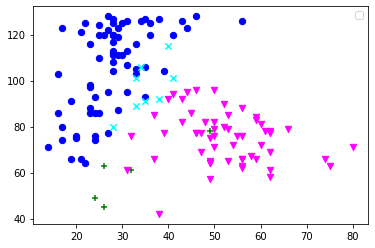

In [64]:
clf=LinearDiscriminantAnalysis()
clf.fit(reduced_x_train,y_train_1_7)
y_pred=clf.predict(reduced_x_test)
con=confusion_matrix(y_test_1_7, y_pred)
print(con)
print(accuracy_score(y_test_1_7, y_pred),
      precision_score(y_test_1_7, y_pred),
      recall_score(y_test_1_7,y_pred),f1_score(y_test_1_7, y_pred))
for i in range(0,len(y_test_1_7)):
    if y_pred[i]!=y_test_1_7[i]:
        if y_test_1_7[i]==1:
            plt.scatter(reduced_x_test[i,0],reduced_x_test[i,1], marker = '+', color = 'green', s = 40)#wrong1
        if y_test_1_7[i]==7:
            plt.scatter(reduced_x_test[i,0],reduced_x_test[i,1],marker = 'x', color = 'cyan', s = 40)#wrong0
    else:
        if y_test_1_7[i]==1:
            plt.scatter(reduced_x_test[i,0],reduced_x_test[i,1], marker = 'o', color = 'blue', s = 40)#right1
        if y_test_1_7[i]==7:
            plt.scatter(reduced_x_test[i,0],reduced_x_test[i,1], marker = 'v', color = 'magenta', s = 40)#right0
plt.legend(loc = 'best')   
plt.show()
